Exercise 10.

Neural machine translation with attention Tutorial  
https://www.tensorflow.org/text/tutorials/nmt_with_attention

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [3]:
import os

DATASETS_DIR = os.path.join(os.pardir, 'datasets')
FRA_ENG_DIR = os.path.join(DATASETS_DIR, 'fra-eng')
FRA_DIR = os.path.join(FRA_ENG_DIR, 'fra.txt')

In [4]:
with open(FRA_DIR, encoding='utf8') as f:
    lines = f.readlines()
    pairs = [line.split('\t') for line in lines]

In [5]:
pairs[-1]

['It may be impossible to get a completely error-free corpus due to the nature of this kind of collaborative effort. However, if we encourage members to contribute sentences in their own languages rather than experiment in languages they are learning, we might be able to minimize errors.',
 "Il est peut-être impossible d'obtenir un Corpus complètement dénué de fautes, étant donnée la nature de ce type d'entreprise collaborative. Cependant, si nous encourageons les membres à produire des phrases dans leurs propres langues plutôt que d'expérimenter dans les langues qu'ils apprennent, nous pourrions être en mesure de réduire les erreurs.",
 'CC-BY 2.0 (France) Attribution: tatoeba.org #2024159 (CK) & #2024564 (sacredceltic)\n']

In [6]:
fra = [fra for eng, fra, _ in pairs]
eng = [eng for eng, fra, _ in pairs]

In [7]:
fra[-1]

"Il est peut-être impossible d'obtenir un Corpus complètement dénué de fautes, étant donnée la nature de ce type d'entreprise collaborative. Cependant, si nous encourageons les membres à produire des phrases dans leurs propres langues plutôt que d'expérimenter dans les langues qu'ils apprennent, nous pourrions être en mesure de réduire les erreurs."

In [8]:
eng[-1]

'It may be impossible to get a completely error-free corpus due to the nature of this kind of collaborative effort. However, if we encourage members to contribute sentences in their own languages rather than experiment in languages they are learning, we might be able to minimize errors.'

In [9]:
BUFFER_SIZE = len(fra)
BATCH_SIZE = 64

dataset = tf.data.Dataset.from_tensor_slices((fra, eng)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)

In [10]:
for example_input_batch, example_target_batch in dataset.take(1):
    print(example_input_batch[:5])
    print()
    print(example_target_batch[:5])
    break

tf.Tensor(
[b'Elle est morte de la tuberculose.'
 b"J'ai oubli\xc3\xa9 ma carte de cr\xc3\xa9dit \xc3\xa0 la maison."
 b'Tom est encore jeune.' b'Je voulais te parler \xc3\xa0 ce propos.'
 b"Il remercia l'h\xc3\xb4te pour la tr\xc3\xa8s divertissante f\xc3\xaate."], shape=(5,), dtype=string)

tf.Tensor(
[b'She died from TB.' b'I left my card at home.' b'Tom is still young.'
 b'I wanted to speak to you about this.'
 b'He thanked the host for the very enjoyable party.'], shape=(5,), dtype=string)


In [11]:
import tensorflow_text as tf_text

example_text = tf.constant('être né dans le neuvième')

print(example_text.numpy())
print(tf_text.normalize_utf8(example_text, 'NFKD').numpy())

b'\xc3\xaatre n\xc3\xa9 dans le neuvi\xc3\xa8me'
b'e\xcc\x82tre ne\xcc\x81 dans le neuvie\xcc\x80me'


In [12]:
def tf_lower_and_split_punct(text):
    text = tf_text.normalize_utf8(text, 'NFKD')
    text = tf.strings.lower(text)
    text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
    text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
    text = tf.strings.strip(text)
    text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
    return text

In [13]:
print(example_text.numpy().decode())
print(tf_lower_and_split_punct(example_text).numpy().decode())

être né dans le neuvième
[START] etre ne dans le neuvieme [END]


In [14]:
from tensorflow.keras.layers.experimental import preprocessing

max_vocab_size = 5000

input_text_processor = preprocessing.TextVectorization(
    standardize=tf_lower_and_split_punct, 
    max_tokens=max_vocab_size)

In [15]:
input_text_processor.adapt(fra)

input_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', '.', 'je', 'de', 'a', '?', 'pas']

In [16]:
output_text_processor = preprocessing.TextVectorization(
    standardize=tf_lower_and_split_punct, 
    max_tokens=max_vocab_size)

output_text_processor.adapt(eng)
output_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', '.', 'i', 'you', 'to', 'the', '?']

In [17]:
example_tokens = input_text_processor(example_input_batch)
example_tokens[:3, :10]

<tf.Tensor: shape=(3, 10), dtype=int64, numpy=
array([[   2,   33,   17, 1288,    6,   11,    1,    4,    3,    0],
       [   2,   26,  382,   42,  713,    6, 2015,    7,   11,  104],
       [   2,   15,   17,  119,  356,    4,    3,    0,    0,    0]],
      dtype=int64)>

In [18]:
input_vocab = np.array(input_text_processor.get_vocabulary())
tokens = input_vocab[example_tokens[0].numpy()]
' '.join(tokens)

'[START] elle est morte de la [UNK] . [END]                  '

Text(0.5, 1.0, 'Mask')

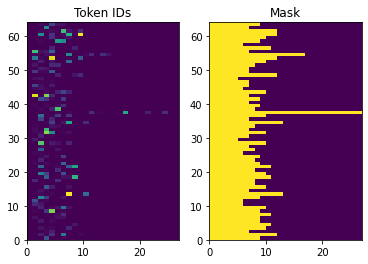

In [19]:
import matplotlib.pyplot as plt

plt.subplot(1, 2, 1)
plt.pcolormesh(example_tokens)
plt.title('Token IDs')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens != 0)
plt.title('Mask')

In [20]:
class ShapeChecker():
    def __init__(self):
        self.shapes = {}
        
    def __call__(self, tensor, names, broadcast=False):
        if not tf.executing_eagerly():
            return
        
        if isinstance(names, str):
            names = (names,)

        shape = tf.shape(tensor)
        rank = tf.rank(tensor)
        
        if rank != len(names):
            raise ValueError(f'Rank mismatch:\n'
                             f'    found {rank}: {shape.numpy()}\n'
                             f'    expected {len(names)}: {names}\n')

        for i, name in enumerate(names):
            if isinstance(name, int):
                old_dim = name
            else:
                old_dim = self.shapes.get(name, None)
            new_dim = shape[i]
            
            if (broadcast and new_dim == 1):
                continue
                
            if old_dim is None:
                self.shapes[name] = new_dim
                continue
                
            if new_dim != old_dim:
                raise ValueError(f"Shape mismatch for dimension: '{name}'\n"
                                 f"    found: {new_dim}\n"
                                 f"    expected: {old_dim}\n")

In [21]:
embedding_dim = 256
units = 1024

In [22]:
class Encoder(keras.layers.Layer):
    def __init__(self, input_vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        self.enc_units = enc_units
        self.input_vocab_size = input_vocab_size
        self.embedding = keras.layers.Embedding(self.input_vocab_size, 
                                                embedding_dim)
        self.gru = keras.layers.GRU(self.enc_units, 
                                    return_sequences=True, 
                                    return_state=True, 
                                    recurrent_initializer='glorot_uniform')
        
    def call(self, tokens, state=None):
        shape_checker = ShapeChecker()
        shape_checker(tokens, ('batch', 's'))
        vectors = self.embedding(tokens)
        shape_checker(vectors, ('batch', 's', 'embed_dim'))
        output, state = self.gru(vectors, initial_state=state)
        shape_checker(output, ('batch', 's', 'enc_units'))
        shape_checker(state, ('batch', 'enc_units'))
        return output, state

In [23]:
example_tokens = input_text_processor(example_input_batch)
encoder = Encoder(input_text_processor.vocabulary_size(), 
                  embedding_dim, units)
example_enc_output, example_enc_state = encoder(example_tokens)

print(f'Input batch, shape (batch): {example_input_batch.shape}')
print(f'Input batch tokens, shape (batch, s): {example_tokens.shape}')
print(f'Encoder output, shape (batch, s, units): {example_enc_output.shape}')
print(f'Encoder state, shape (batch, units): {example_enc_state.shape}')

Input batch, shape (batch): (64,)
Input batch tokens, shape (batch, s): (64, 27)
Encoder output, shape (batch, s, units): (64, 27, 1024)
Encoder state, shape (batch, units): (64, 1024)


In [24]:
class BahdanauAttention(keras.layers.Layer):
    def __init__(self, units):
        super().__init__()
        self.W1 = keras.layers.Dense(units, use_bias=False)
        self.W2 = keras.layers.Dense(units, use_bias=False)
        self.attention = keras.layers.AdditiveAttention()
        
    def call(self, query, value, mask):
        shape_checker = ShapeChecker()
        shape_checker(query, ('batch', 't', 'query_units'))
        shape_checker(value, ('batch', 's', 'value_units'))
        shape_checker(mask, ('batch', 's'))
        w1_query = self.W1(query)
        shape_checker(w1_query, ('batch', 't', 'attn_units'))
        w2_key = self.W2(value)
        shape_checker(w2_key, ('batch', 's', 'attn_units'))
        query_mask = tf.ones(tf.shape(query)[:-1], dtype=bool)
        value_mask = mask
        context_vector, attention_weights = self.attention(
            inputs = [w1_query, value, w2_key], 
            mask=[query_mask, value_mask], 
            return_attention_scores = True)
        shape_checker(context_vector, ('batch', 't', 'value_units'))
        shape_checker(attention_weights, ('batch', 't', 's'))
        return context_vector, attention_weights

In [25]:
attention_layer = BahdanauAttention(units)

In [26]:
(example_tokens != 0).shape

TensorShape([64, 27])

In [27]:
example_attention_query = tf.random.normal(
    shape=[len(example_tokens), 2, 10])
context_vector, attention_weights = attention_layer(
    query=example_attention_query,
    value=example_enc_output,
    mask=(example_tokens != 0))

print(f'Attention result shape: (batch_size, query_seq_length, units):           {context_vector.shape}')
print(f'Attention weights shape: (batch_size, query_seq_length, value_seq_length): {attention_weights.shape}')

Attention result shape: (batch_size, query_seq_length, units):           (64, 2, 1024)
Attention weights shape: (batch_size, query_seq_length, value_seq_length): (64, 2, 27)


Text(0.5, 1.0, 'Mask')

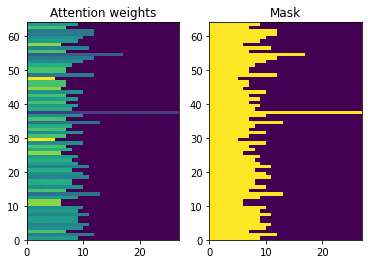

In [28]:
plt.subplot(1, 2, 1)
plt.pcolormesh(attention_weights[:, 0, :])
plt.title('Attention weights')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens != 0)
plt.title('Mask')

In [29]:
attention_weights.shape

TensorShape([64, 2, 27])

In [30]:
attention_slice = attention_weights[0, 0].numpy()
attention_slice = attention_slice[attention_slice != 0]

<Figure size 432x288 with 0 Axes>

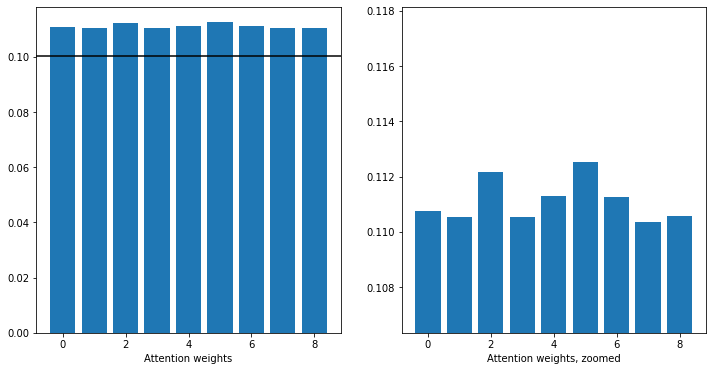

In [31]:
plt.suptitle('Attention weights for one sequence')

plt.figure(figsize=(12, 6))
a1 = plt.subplot(1, 2, 1)
plt.bar(range(len(attention_slice)), attention_slice)
# freeze the xlim
plt.xlim(plt.xlim())
plt.xlabel('Attention weights')

a2 = plt.subplot(1, 2, 2)
plt.bar(range(len(attention_slice)), attention_slice)
plt.xlabel('Attention weights, zoomed')

# zoom in
top = max(a1.get_ylim())
zoom = 0.85*top
a2.set_ylim([0.90*top, top])
a1.plot(a1.get_xlim(), [zoom, zoom], color='k')

In [32]:
class Decoder(keras.layers.Layer):
    def __init__(self, output_vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.output_vocab_size = output_vocab_size
        self.embedding_dim = embedding_dim
        
        self.embedding = keras.layers.Embedding(self.output_vocab_size, 
                                                embedding_dim)
        self.gru = keras.layers.GRU(self.dec_units, 
                                    return_sequences=True,
                                    return_state=True, 
                                    recurrent_initializer='glorot_uniform')
        self.attention = BahdanauAttention(self.dec_units)
        self.Wc = keras.layers.Dense(dec_units, 
                                     activation=tf.math.tanh, 
                                     use_bias=True)
        self.fc = keras.layers.Dense(self.output_vocab_size)

In [33]:
from typing import Any, NamedTuple, Tuple

class DecoderInput(NamedTuple):
    new_tokens: Any
    enc_output: Any
    mask: Any

class DecoderOutput(NamedTuple):
    logits: Any
    attention_weights: Any

In [34]:
from typing import Tuple

def call(self,
         inputs: DecoderInput, 
         state=None) -> Tuple[DecoderOutput, tf.Tensor]:
    shape_checker = ShapeChecker()
    shape_checker(inputs.new_tokens, ('batch', 't'))
    shape_checker(inputs.enc_output, ('batch', 's', 'enc_units'))
    shape_checker(inputs.mask, ('batch', 's'))
    
    if state is not None:
        shape_checker(state, ('batch', 'dec_units'))
        
    vectors = self.embedding(inputs.new_tokens)
    shape_checker(vectors, ('batch', 't', 'embedding_dim'))
    
    rnn_output, state = self.gru(vectors, initial_state=state)
    shape_checker(rnn_output, ('batch', 't', 'dec_units'))
    shape_checker(state, ('batch', 'dec_units'))
    
    context_vector, attention_weights = self.attention(
        query=rnn_output, value=inputs.enc_output, mask=inputs.mask)
    shape_checker(context_vector, ('batch', 't', 'dec_units'))
    shape_checker(attention_weights, ('batch', 't', 's'))
    
    context_and_rnn_output = tf.concat([context_vector, rnn_output], axis=-1)
    
    attention_vector = self.Wc(context_and_rnn_output)
    shape_checker(attention_vector, ('batch', 't', 'dec_units'))
    
    logits = self.fc(attention_vector)
    shape_checker(logits, ('batch', 't', 'output_vocab_size'))
    
    return DecoderOutput(logits, attention_weights), state

In [35]:
Decoder.call = call

In [36]:
decoder = Decoder(output_text_processor.vocabulary_size(), 
                  embedding_dim, 
                  units)

In [37]:
example_output_tokens = output_text_processor(example_target_batch)

start_index = output_text_processor.get_vocabulary().index('[START]')
first_token = tf.constant([[start_index]] * example_output_tokens.shape[0])

In [38]:
dec_result, dec_state = decoder(
    inputs = DecoderInput(new_tokens=first_token, 
                          enc_output=example_enc_output, 
                          mask=(example_tokens != 0)), 
    state = example_enc_state)

print(f'logits shape: (batch_size, t, output_vocab_size) {dec_result.logits.shape}')
print(f'state shape: (batch_size, dec_units) {dec_state.shape}')

logits shape: (batch_size, t, output_vocab_size) (64, 1, 5000)
state shape: (batch_size, dec_units) (64, 1024)


In [39]:
sampled_token = tf.random.categorical(dec_result.logits[:, 0, :], num_samples=1)

In [40]:
vocab = np.array(output_text_processor.get_vocabulary())
first_word = vocab[sampled_token.numpy()]
first_word[:5]

array([['patient'],
       ['spare'],
       ['mouse'],
       ['provided'],
       ['clients']], dtype='<U16')

In [41]:
dec_result, dec_state = decoder(
    DecoderInput(sampled_token, 
                 example_enc_output, 
                 mask=(example_tokens != 0)), 
    state=dec_state)

In [42]:
sampled_token = tf.random.categorical(
    dec_result.logits[:, 0, :], num_samples=1)
first_word = vocab[sampled_token.numpy()]
first_word[:5]

array([['stable'],
       ['occupied'],
       ['mat'],
       ['tough'],
       ['relax']], dtype='<U16')

In [43]:
class MaskedLoss(keras.losses.Loss):
    def __init__(self):
        self.name = 'masked_loss'
        self.loss = keras.losses.SparseCategoricalCrossentropy(
            from_logits=True, reduction='none')
        
    def __call__(self, y_true, y_pred):
        shape_checker = ShapeChecker()
        shape_checker(y_true, ('batch', 't'))
        shape_checker(y_pred, ('batch', 't', 'logits'))
        
        loss = self.loss(y_true, y_pred)
        shape_checker(loss, ('batch', 't'))
        
        mask = tf.cast(y_true != 0, tf.float32)
        shape_checker(mask, ('batch', 't'))
        loss *= mask
        
        return tf.reduce_sum(loss)

In [44]:
class TrainTranslator(keras.Model):
    def __init__(self, embedding_dim, units, 
                 input_text_processor, 
                 output_text_processor, 
                 use_tf_function=True):
        super().__init__()
        encoder = Encoder(input_text_processor.vocabulary_size(), 
                          embedding_dim, units)
        decoder = Decoder(output_text_processor.vocabulary_size(), 
                          embedding_dim, units)
        
        self.encoder = encoder
        self.decoder = decoder
        self.input_text_processor = input_text_processor
        self.output_text_processor = output_text_processor
        self.use_tf_function = use_tf_function
        self.shape_checker = ShapeChecker()
        
    def train_step(self, inputs):
        self.shape_checker = ShapeChecker()
        if self.use_tf_function:
            return self._tf_train_step(inputs)
        else:
            return self._train_step(inputs)
        
    def _preprocess(self, input_text, target_text):
        self.shape_checker(input_text, ('batch'))
        self.shape_checker(target_text, ('batch'))
        
        input_tokens = self.input_text_processor(input_text)
        target_tokens = self.output_text_processor(target_text)
        self.shape_checker(input_tokens, ('batch', 's'))
        self.shape_checker(target_tokens, ('batch', 't'))
        
        input_mask = input_tokens != 0
        self.shape_checker(input_mask, ('batch', 's'))
        
        target_mask = target_tokens != 0
        self.shape_checker(target_mask, ('batch', 't'))
        
        return input_tokens, input_mask, target_tokens, target_mask
    
    def _train_step(self, inputs):
        input_text, target_text = inputs
        
        (input_tokens, input_mask, 
         target_tokens, target_mask) = self._preprocess(input_text, target_text)
        
        max_target_length = tf.shape(target_tokens)[1]
        
        with tf.GradientTape() as tape:
            enc_output, enc_state = self.encoder(input_tokens)
            self.shape_checker(enc_output, ('batch', 's', 'enc_units'))
            self.shape_checker(enc_state, ('batch', 'enc_units'))
            
            dec_state = enc_state
            loss = tf.constant(0.0)
            
            for t in tf.range(max_target_length - 1):
                new_tokens = target_tokens[:, t:t+2]
                step_loss, dec_state = self._loop_step(new_tokens, input_mask, 
                                                       enc_output, dec_state)
                loss = loss + step_loss
                
            average_loss = loss / tf.reduce_sum(tf.cast(target_mask, tf.float32))
            
        variables = self.trainable_variables
        gradients = tape.gradient(average_loss, variables)
        self.optimizer.apply_gradients(zip(gradients, variables))
        
        return {'batch_loss': average_loss}
    
    def _loop_step(self, new_tokens, input_mask, enc_output, dec_state):
        input_token, target_token = new_tokens[:, 0:1], new_tokens[:, 1:2]
        
        decoder_input = DecoderInput(new_tokens=input_token, 
                                     enc_output=enc_output, 
                                     mask=input_mask)
        
        dec_result, dec_state = self.decoder(decoder_input, state=dec_state)
        self.shape_checker(dec_result.logits, ('batch', 't1', 'logits'))
        self.shape_checker(dec_result.attention_weights, ('batch', 't1', 's'))
        self.shape_checker(dec_state, ('batch', 'dec_units'))
        
        y = target_token
        y_pred = dec_result.logits
        step_loss = self.loss(y, y_pred)
        
        return step_loss, dec_state

In [45]:
translator = TrainTranslator(
    embedding_dim, units, 
    input_text_processor=input_text_processor, 
    output_text_processor=output_text_processor, 
    use_tf_function=False)

translator.compile(
    optimizer=tf.optimizers.Adam(), 
    loss=MaskedLoss())

In [46]:
np.log(output_text_processor.vocabulary_size())

8.517193191416238

In [47]:
%%time
for n in range(10):
    print(translator.train_step([example_input_batch, example_target_batch]))
print()

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.560233>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.524635>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.456215>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.25171>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=6.4278836>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=5.2806935>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.5264616>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.406558>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.2941833>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.1096563>}

Wall time: 6.65 s


In [48]:
@tf.function(input_signature=[[tf.TensorSpec(dtype=tf.string, shape=[None]), 
                               tf.TensorSpec(dtype=tf.string, shape=[None])]])
def _tf_train_step(self, inputs):
    return self._train_step(inputs)

In [49]:
TrainTranslator._tf_train_step = _tf_train_step

In [50]:
translator.use_tf_function = True

In [51]:
translator.train_step([example_input_batch, example_target_batch])

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.9945557>}

In [52]:
%%time
for n in range(10):
    print(translator.train_step([example_input_batch, example_target_batch]))
print()

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.9758716>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.9651706>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.8696537>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.7348306>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.7063837>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.674823>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.6340756>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.628816>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.5692387>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=5.637944>}

Wall time: 7.78 s


....................................................................................................


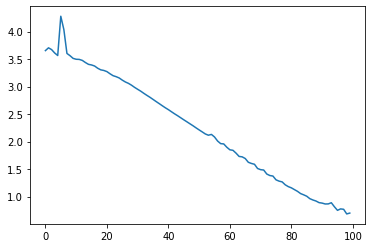

In [53]:
losses = []
for n in range(100):
    print('.', end='')
    logs = translator.train_step([example_input_batch, example_target_batch])
    losses.append(logs['batch_loss'].numpy())
print()
plt.plot(losses)

In [54]:
class BatchLogs(keras.callbacks.Callback):
    def __init__(self, key):
        self.key = key
        self.logs = []
        
    def on_train_batch_end(self, n, logs):
        self.logs.append(logs[self.key])

In [55]:
train_translator = TrainTranslator(
    embedding_dim, units, 
    input_text_processor=input_text_processor, 
    output_text_processor=output_text_processor)

train_translator.compile(
    optimizer=tf.optimizers.Adam(), 
    loss=MaskedLoss())

batch_loss = BatchLogs('batch_loss')

In [56]:
train_translator.fit(dataset, epochs=5, 
                     callbacks=[batch_loss])

Epoch 1/5
2972/2972 [==============================] - 1528s 513ms/step - batch_loss: 1.6716
Epoch 2/5
2972/2972 [==============================] - 1586s 534ms/step - batch_loss: 0.8832
Epoch 3/5
2972/2972 [==============================] - 1651s 555ms/step - batch_loss: 0.6832
Epoch 4/5
2972/2972 [==============================] - 1567s 527ms/step - batch_loss: 0.5417
Epoch 5/5
2972/2972 [==============================] - 1567s 527ms/step - batch_loss: 0.4346


Text(0, 0.5, 'CE/token')

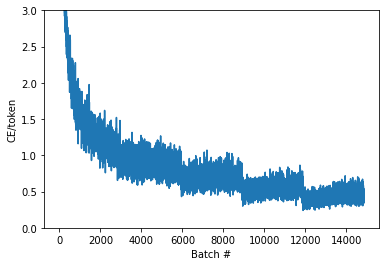

In [57]:
plt.plot(batch_loss.logs)
plt.ylim([0, 3])
plt.xlabel('Batch #')
plt.ylabel('CE/token')

In [58]:
class Translator(tf.Module):
    def __init__(self, encoder, decoder, input_text_processor, 
                 output_text_processor):
        self.encoder = encoder
        self.decoder = decoder
        self.input_text_processor = input_text_processor
        self.output_text_processor = output_text_processor
        
        self.output_token_string_from_index = (
            keras.layers.experimental.preprocessing.StringLookup(
                vocabulary=output_text_processor.get_vocabulary(), 
                mask_token='', invert=True))
        
        index_from_string = keras.layers.experimental.preprocessing.StringLookup(
            vocabulary=output_text_processor.get_vocabulary(), mask_token='')
        token_mask_ids = index_from_string(['', '[UNK]', '[START]']).numpy()
        
        token_mask = np.zeros([index_from_string.vocabulary_size()], dtype=np.bool)
        token_mask[np.array(token_mask_ids)] = True
        self.token_mask = token_mask
        
        self.start_token = index_from_string(tf.constant('[START]'))
        self.end_token = index_from_string(tf.constant('[END]'))

In [59]:
translator = Translator(
    encoder=train_translator.encoder, 
    decoder=train_translator.decoder, 
    input_text_processor=input_text_processor, 
    output_text_processor=output_text_processor)

In [60]:
def tokens_to_text(self, result_tokens):
    shape_checker = ShapeChecker()
    shape_checker(result_tokens, ('batch', 't'))
    result_text_tokens = self.output_token_string_from_index(result_tokens)
    shape_checker(result_text_tokens, ('batch', 't'))
    
    result_text = tf.strings.reduce_join(result_text_tokens, 
                                         axis=1, separator=' ')
    shape_checker(result_text, ('batch'))
    
    result_text = tf.strings.strip(result_text)
    shape_checker(result_text, ('batch'))
    return result_text

In [61]:
Translator.tokens_to_text = tokens_to_text

In [62]:
example_output_tokens = tf.random.uniform(
    shape=[5, 2], minval=0, dtype=tf.int64,
    maxval=output_text_processor.vocabulary_size())
translator.tokens_to_text(example_output_tokens).numpy()

array([b'argued travel', b'clue flowers', b'start stand', b'port seems',
       b'fail coincidence'], dtype=object)

In [63]:
def sample(self, logits, temperature):
    shape_checker = ShapeChecker()
    shape_checker(logits, ('batch', 't', 'vocab'))
    shape_checker(self.token_mask, ('vocab'))
    
    token_mask = self.token_mask[tf.newaxis, tf.newaxis, :]
    shape_checker(token_mask, ('batch', 't', 'vocab'), broadcast=True)
    
    logits = tf.where(self.token_mask, -np.inf, logits)
    
    if temperature == 0.0:
        new_tokens = tf.argmax(logits, axis=-1)
    else:
        logits = tf.squeeze(logits, axis=1)
        new_tokens = tf.random.categorical(logits/temperature, num_samples=1)
        
    shape_checker(new_tokens, ('batch', 't'))
    
    return new_tokens

In [64]:
Translator.sample = sample

In [65]:
example_logits = tf.random.normal([5, 1, output_text_processor.vocabulary_size()])
example_output_tokens = translator.sample(example_logits, temperature=1.0)
example_output_tokens

<tf.Tensor: shape=(5, 1), dtype=int64, numpy=
array([[4761],
       [  84],
       [ 257],
       [1036],
       [4093]], dtype=int64)>

In [66]:
def translate_unrolled(self, 
                       input_text, *, 
                       max_length=50, 
                       return_attention=True, 
                       temperature=1.0):
    batch_size = tf.shape(input_text)[0]
    input_tokens = self.input_text_processor(input_text)
    enc_output, enc_state = self.encoder(input_tokens)
    
    dec_state = enc_state
    new_tokens = tf.fill([batch_size, 1], self.start_token)
    
    result_tokens = []
    attention = []
    done = tf.zeros([batch_size, 1], dtype=tf.bool)
    
    for _ in range(max_length):
        dec_input = DecoderInput(new_tokens=new_tokens, 
                                 enc_output=enc_output, 
                                 mask=(input_tokens != 0))
        dec_result, dec_state = self.decoder(dec_input, state=dec_state)
        
        attention.append(dec_result.attention_weights)
        
        new_tokens = self.sample(dec_result.logits, temperature)
        
        done = done | (new_tokens == self.end_token)
        new_tokens = tf.where(done, tf.constant(0, dtype=tf.int64), new_tokens)
        
        result_tokens.append(new_tokens)
        
        if tf.executing_eagerly() and tf.reduce_all(done):
            break
        
    result_tokens = tf.concat(result_tokens, axis=-1)
    result_text = self.tokens_to_text(result_tokens)
    
    if return_attention:
        attention_stack = tf.concat(attention, axis=1)
        return {'text': result_text, 'attention': attention_stack}
    else:
        return {'text': result_text}

In [67]:
Translator.translate = translate_unrolled

In [68]:
%%time
input_text = tf.constant([
    "Merci beaucoup", # "thank you so much"
    "Quelle heure est-il ?" # "What time is it?"
])

result = translator.translate(input_text=input_text)

print(result['text'][0].numpy().decode())
print(result['text'][1].numpy().decode())
print()

thanks very much for you very much .
what time is it now ?

Wall time: 179 ms


In [69]:
@tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None])])
def tf_translate(self, input_text):
    return self.translate(input_text)

Translator.tf_translate =tf_translate

In [70]:
%%time
result = translator.tf_translate(input_text=input_text)

Wall time: 12.9 s


In [71]:
%%time
result = translator.tf_translate(input_text=input_text)

print(result['text'][0].numpy().decode())
print(result['text'][1].numpy().decode())
print()

thanks a lot .
what time is it ?

Wall time: 154 ms


In [72]:
def translate_symbolic(self, 
                       input_text, 
                       *, 
                       max_length=50, 
                       return_attention=True, 
                       temperature=1.0):
    shape_checker = ShapeChecker()
    shape_checker(input_text, ('batch'))
    batch_size = tf.shape(input_text)[0]
    
    input_tokens = self.input_text_processor(input_text)
    shape_checker(input_tokens, ('batch', 's'))
    
    enc_output, enc_state = self.encoder(input_tokens)
    shape_checker(enc_output, ('batch', 's', 'enc_units'))
    shape_checker(enc_state, ('batch', 'enc_units'))
    
    dec_state = enc_state
    new_tokens = tf.fill([batch_size, 1], self.start_token)
    shape_checker(new_tokens, ('batch', 't1'))
    
    result_tokens = tf.TensorArray(tf.int64, size=1, dynamic_size=True)
    attention = tf.TensorArray(tf.float32, size=1, dynamic_size=True)
    done = tf.zeros([batch_size, 1], dtype=tf.bool)
    shape_checker(done, ('batch', 't1'))
    
    for t in tf.range(max_length):
        dec_input = DecoderInput(
            new_tokens=new_tokens, 
            enc_output=enc_output, 
            mask=(input_tokens != 0))
        
        dec_result, dec_state = self.decoder(dec_input, state=dec_state)
        
        shape_checker(dec_result.attention_weights, ('batch', 't1', 's'))
        attention = attention.write(t, dec_result.attention_weights)
        
        new_tokens = self.sample(dec_result.logits, temperature)
        shape_checker(dec_result.logits, ('batch', 't1', 'vocab'))
        shape_checker(new_tokens, ('batch', 't1'))
        
        done = done | (new_tokens == self.end_token)
        
        new_tokens = tf.where(done, tf.constant(0, dtype=tf.int64), new_tokens)
        
        result_tokens = result_tokens.write(t, new_tokens)
        
        if tf.reduce_all(done):
            break
            
    result_tokens = result_tokens.stack()
    shape_checker(result_tokens, ('t', 'batch', 't0'))
    result_tokens = tf.squeeze(result_tokens, -1)
    result_tokens = tf.transpose(result_tokens, [1, 0])
    shape_checker(result_tokens, ('batch', 't'))
    
    result_text = self.tokens_to_text(result_tokens)
    shape_checker(result_text, ('batch',))
    
    if return_attention:
        attention_stack = attention.stack()
        shape_checker(attention_stack, ('t', 'batch', 't1', 's'))
        
        attention_stack = tf.squeeze(attention_stack, 2)
        shape_checker(attention_stack, ('t', 'batch', 's'))
        
        attention_stack = tf.transpose(attention_stack, [1, 0, 2])
        shape_checker(attention_stack, ('batch', 't', 's'))
        
        return {'text': result_text, 'attention': attention_stack}
    else:
        return {'text': result_text}

In [73]:
Translator.translate = translate_symbolic

In [74]:
%%time
result = translator.translate(input_text=input_text)

print(result['text'][0].numpy().decode())
print(result['text'][1].numpy().decode())
print()

do you very much in a lot .
what time is it now ?

Wall time: 198 ms


In [75]:
@tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None])])
def tf_translate(self, input_text):
    return self.translate(input_text)

Translator.tf_translate =tf_translate

In [76]:
%%time
result = translator.tf_translate(input_text=input_text)

Wall time: 899 ms


In [77]:
%%time
result = translator.tf_translate(input_text=input_text)

print(result['text'][0].numpy().decode())
print(result['text'][1].numpy().decode())
print()

thanks very much for you very much .
what time is it now ?

Wall time: 51 ms


In [78]:
a = result['attention'][0]

print(np.sum(a, axis=-1))

[1.         1.         1.         0.99999994 1.         1.
 1.         1.         1.        ]


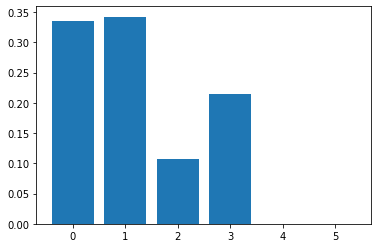

In [79]:
_ = plt.bar(range(len(a[0, :])), a[0, :])

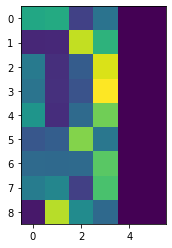

In [80]:
plt.imshow(np.array(a), vmin=0.0)

In [81]:
import matplotlib.ticker as ticker

def plot_attention(attention, sentence, predicted_sentence):
    sentence = tf_lower_and_split_punct(sentence).numpy().decode().split()
    predicted_sentence = predicted_sentence.numpy().decode().split() + ['[END]']
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    
    attention = attention[:len(predicted_sentence), :len(sentence)]
    
    ax.matshow(attention, cmap='viridis', vmin=0.0)
    
    fontdict = {'fontsize': 14}
    
    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)
    
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    
    ax.set_xlabel('Input text')
    ax.set_ylabel('Output text')
    plt.suptitle('Attention weights')

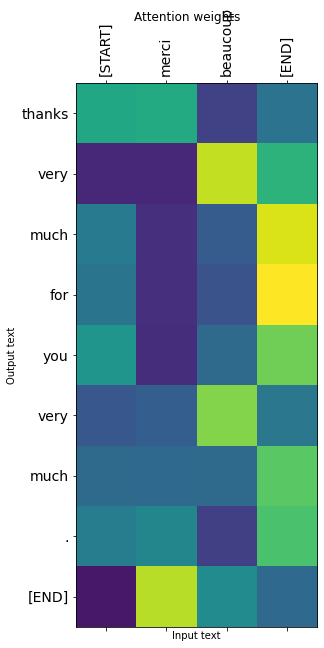

In [82]:
i = 0
plot_attention(result['attention'][i], input_text[i], result['text'][i])

In [83]:
%%time
three_input_text = tf.constant([
    # We need to buy some food.
    "Nous devons acheter à manger.",
    # She asked me how old I was. 
    "Elle m’a demandé quel âge j’avais.",
    # We went on a trip to the Lake District. 
    "Nous sommes allés dans le Lake District."
])

result = translator.tf_translate(three_input_text)

for tr in result['text']:
    print(tr.numpy().decode())
print()

we have to buy gifts .
she asked me which age was .
we went into the honor of the director .

Wall time: 48 ms


In [84]:
result['text']

<tf.Tensor: shape=(3,), dtype=string, numpy=
array([b'we have to buy gifts .', b'she asked me which age was .',
       b'we went into the honor of the director .'], dtype=object)>

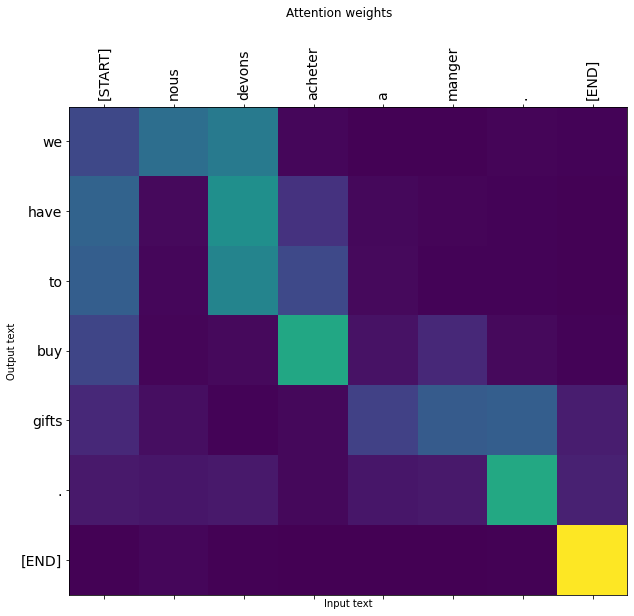

In [85]:
i = 0
plot_attention(result['attention'][i], three_input_text[i], result['text'][i])

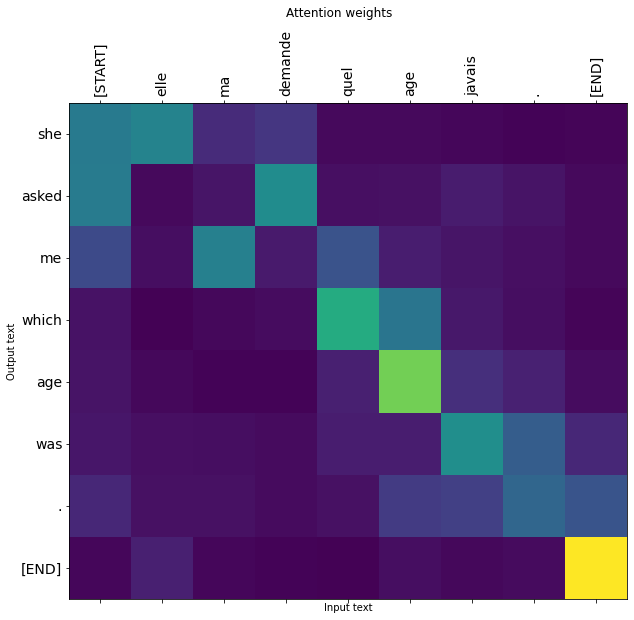

In [86]:
i = 1
plot_attention(result['attention'][i], three_input_text[i], result['text'][i])

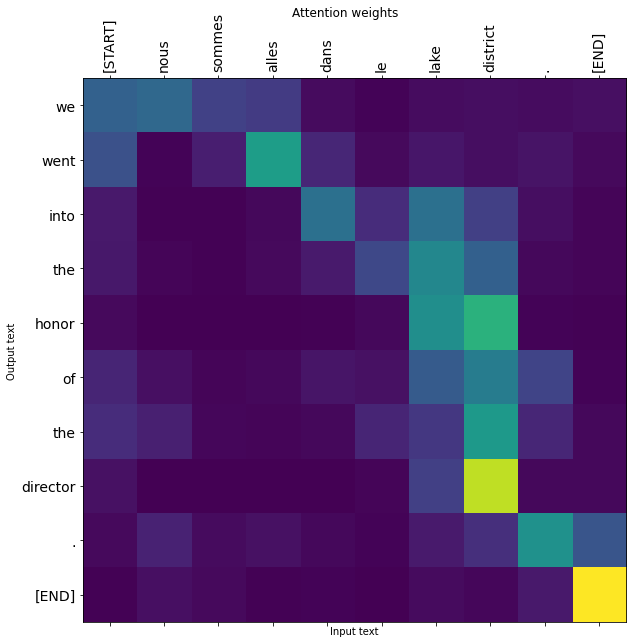

In [87]:
i = 2
plot_attention(result['attention'][i], three_input_text[i], result['text'][i])

In [88]:
long_input_text = tf.constant([fra[-1]])

import textwrap
print('Expected output:\n', '\n'.join(textwrap.wrap(eng[-1])))

Expected output:
 It may be impossible to get a completely error-free corpus due to the
nature of this kind of collaborative effort. However, if we encourage
members to contribute sentences in their own languages rather than
experiment in languages they are learning, we might be able to
minimize errors.


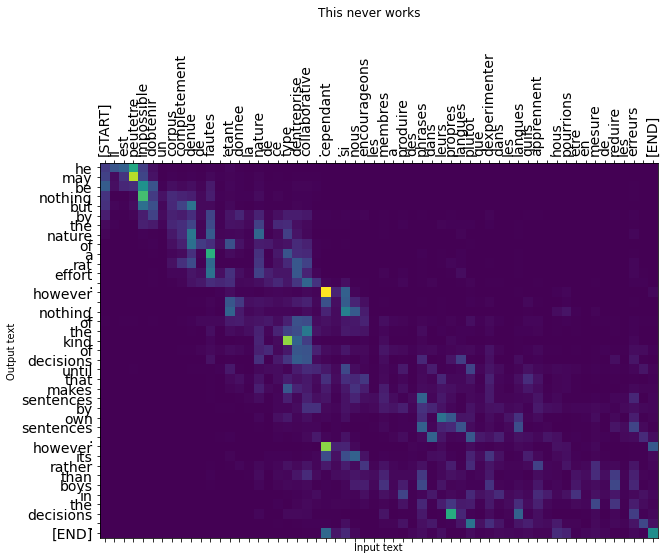

In [89]:
result = translator.tf_translate(long_input_text)

i = 0
plot_attention(result['attention'][i], long_input_text[i], result['text'][i])
_ = plt.suptitle('This never works')

In [90]:
tf.saved_model.save(translator, 'translator', 
                    signatures={
                        'serving_default': translator.tf_translate
                    })

INFO:tensorflow:Assets written to: translator\assets


INFO:tensorflow:Assets written to: translator\assets


In [91]:
reloaded = tf.saved_model.load('translator')
result = reloaded.tf_translate(three_input_text)

In [92]:
%%time
result = reloaded.tf_translate(three_input_text)

for tr in result['text']:
    print(tr.numpy().decode())
print()

we have to buy getting food .
she asked me what age had been .
we went into the honor of the beautiful .

Wall time: 45 ms
